In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy.ext.automap import automap_base
import numpy as np

In [72]:
#Create a conncection to the engine
engine = create_engine('sqlite:///hawaii.db', echo=False)
session = Session(engine)

In [73]:
#Selected Date Range is 7/1/2017 - 7/9/2017
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Stations = Base.classes.stations
Measurements = Base.classes.measurements

In [74]:
results = session.query(Measurements.prcp, Measurements.date).\
    filter(Measurements.date.between('2016-01-01', '2016-12-31')).all()
dates = [result[1].strftime("%d/%m/%y") for result in results]
prcp = [result[0] for result in results]

In [75]:
# Load the query results into a Pandas DataFrame and set the index to the date column.
results_df = pd.DataFrame({'dates':dates,'prcp':prcp})
results_df.head()

,dates,prcp
0,01/01/16,0.0
1,02/01/16,0.0
2,03/01/16,0.0
3,04/01/16,0.0
4,05/01/16,0.0


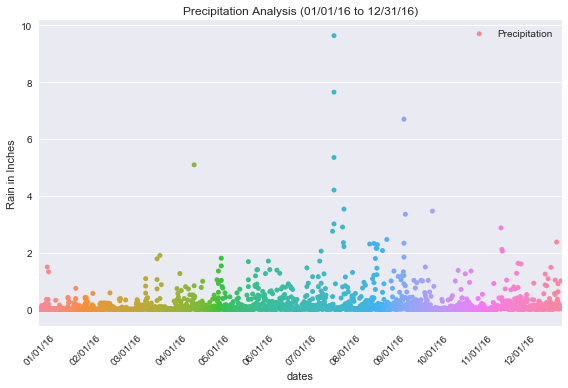

In [81]:
import seaborn as sns

ticks = ['01/01/16', '02/01/16', '03/01/16', '04/01/16', '05/01/16', '06/01/16','07/01/16',\
         '08/01/16', '09/01/16','10/01/16', '11/01/16', '12/01/16']

tick_locs =[0,32,61,92,122,153,183,214,245,275,306,336]

sns.swarmplot(x="dates", y="prcp", data =results_df)
plt.legend(["Precipitation"])
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (01/01/16 to 12/31/16)")
plt.xticks(tick_locs,ticks,rotation =45)
plt.tight_layout()

### Station Analysis

In [9]:
# Design a query to calculate the total number of stations.
results = session.query(Stations.name).count()
print(f'There are {results} stations')

There are 9 stations


In [10]:
# Design a query to find the most active stations.
results = session.query(Stations.name,func.count(Measurements.station)).\
    filter(Measurements.station == Stations.station).\
    group_by(Measurements.station).\
    order_by(func.count(Measurements.station).desc()).all()

print(f'The station {results[0]} had the highest number of observations')

The station ('WAIHEE 837.5, HI US', 2772) had the highest number of observations


In [11]:
#Design a query to retrieve the last 12 months of temperature observation data (tobs).
results = session.query(Measurements.date, Measurements.tobs, Stations.name).\
    filter(Measurements.station == Stations.station).\
    filter(Measurements.date.between('2016-01-01', '2016-12-31')).\
    filter(Stations.name == 'WAIHEE 837.5, HI US').all()
    
df = pd.DataFrame(results)
df.head()

,date,tobs,name
0,2016-01-01,74,"WAIHEE 837.5, HI US"
1,2016-01-02,72,"WAIHEE 837.5, HI US"
2,2016-01-03,68,"WAIHEE 837.5, HI US"
3,2016-01-04,69,"WAIHEE 837.5, HI US"
4,2016-01-05,70,"WAIHEE 837.5, HI US"


In [12]:
df.head()

,date,tobs,name
0,2016-01-01,74,"WAIHEE 837.5, HI US"
1,2016-01-02,72,"WAIHEE 837.5, HI US"
2,2016-01-03,68,"WAIHEE 837.5, HI US"
3,2016-01-04,69,"WAIHEE 837.5, HI US"
4,2016-01-05,70,"WAIHEE 837.5, HI US"


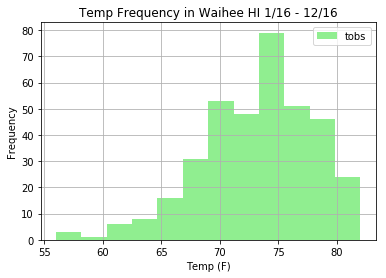

In [13]:
df.plot(kind='hist', bins=12, color ='lightgreen')
plt.title('Temp Frequency in Waihee HI 1/16 - 12/16')
plt.xlabel('Temp (F)')
plt.grid()


### Temperature Analysis

In [14]:
def calc_temps(date1, date2):
    if isinstance(date1, str) and isinstance(date2, str):
        
        sel = [func.max(Measurements.tobs).label('Max'), func.min(Measurements.tobs).label('Min'),\
               func.avg(Measurements.tobs).label('average')]
        calc_results = session.query(*sel).filter(Measurements.date.between(date1, date2)).all()
    return{
        "min_temp":calc_results[0].Min,
        "max_temp":calc_results[0].Max,
        "avg_temp":calc_results[0].average,
        "date_1": date1,
        "date_2": date2
    }      

Text(0,0.5,'Temp F')

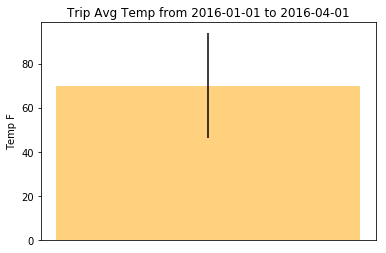

In [15]:
calc_results = calc_temps('2016-01-01', '2016-04-01')
error = (calc_results["max_temp"] - calc_results["min_temp"])
plt.bar(0,calc_results["avg_temp"],yerr = error, color = 'orange', alpha =.5)
plt.xticks([1],['avg'])
plt.title(f'Trip Avg Temp from {calc_results["date_1"]} to {calc_results["date_2"]}')
plt.ylabel('Temp F')

### Optional Recommended Analysis

Calculate the rainfall per weather station using the previous year's matching dates.

In [16]:
results = session.query(func.sum(Measurements.prcp).label('Rainfall'),Stations.name.label('station name')).\
    filter(Measurements.station == Stations.station).\
    filter(Measurements.date.between('2016-01-01', '2016-12-31')).\
    group_by(Measurements.station).all()
df = pd.DataFrame(results)
df

,Rainfall,station name
0,52.15,"KANEOHE 838.1, HI US"
1,27.29,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
2,162.88,"MANOA LYON ARBO 785.2, HI US"
3,2.97,"PEARL CITY, HI US"
4,79.89,"WAIHEE 837.5, HI US"
5,16.15,"WAIKIKI 717.2, HI US"
6,30.77,"WAIMANALO EXPERIMENTAL FARM, HI US"


Calculate the daily normals. Normals are the averages for min, avg, and max temperatures.

In [24]:
def daily_normals(date):
    sel = [func.max(Measurements.tobs).label('Max'), func.min(Measurements.tobs).label('Min'),\
               func.avg(Measurements.tobs).label('Avg')]
    hist_results = session.query(*sel).filter(Measurements.date.like("%" + date)).all()
    
    return {
        "avg_temp": hist_results[0].Avg,
        "max_temp": hist_results[0].Max,
        "min_temp": hist_results[0].Min,
        "date": date
        }


In [39]:
trip_dates =['06-01','06-02','06-03','06-04','06-05']

data = []

for date in trip_dates:
    hist_results = daily_normals(date)
    data.append(hist_results)
df = pd.DataFrame(data)
df = df.set_index('date')

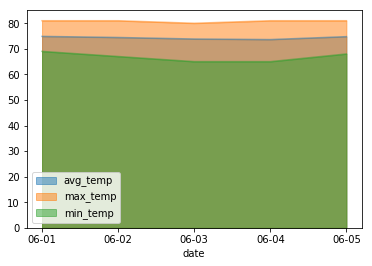

In [55]:
df.plot(kind="area", alpha =.5, stacked = False)
plt.xticks(np.arange(5),('06-01','06-02','06-03','06-04','06-05'))
plt.show()